<a href="https://colab.research.google.com/github/huzaifa003/english_nlp_client/blob/master/SirShahidTaskV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import pandas as pd

# Load the data from the Excel file
file_path = 'Clean_Craniosynostosis-Nonsyndromic.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset to understand its structure and the available variables
data.head()


,Study ID,Age,FU,Description,dob,d/o first visit,referred,[ref],age,dod,...,PLANNED Hardware Removal,Any reoperation? (NOT PLANNED HARDWARE REMOVAL),Reoperation: for complication [DV-DX],Reop: for two-stage (anticipated revision),Reoperation: unanticipated revision,Reoperation: Total reoperations (CVR/FOA),Date of First Reop,Time to reop,Total # reops (related to craniosynostosis),Starting opioids data (see opiates tab)
0,1.0,75.0,13.0,NaN,2022-08-12,2022-10-18,peds,pcp,75.0,2022-10-18 00:00:00,...,0,0.0,0.0,0,0,0,na,na,0,NaN
1,2.0,143.0,43.0,NaN,2022-05-27,2022-10-11,peds,na,143.0,2022-10-11 00:00:00,...,0,0.0,0.0,0,0,0,na,na,0,NaN
2,3.0,77.0,27.0,NaN,2022-07-06,2022-09-07,peds,pcp,77.0,2022-09-07 00:00:00,...,0,0.0,0.0,0,0,0,na,na,0,NaN
3,4.0,136.0,92.0,NaN,2022-04-29,2022-08-25,peds,pcp,136.0,2022-08-25 00:00:00,...,0,0.0,0.0,0,0,0,na,na,0,NaN
4,5.0,77.0,96.0,NaN,2022-06-22,2022-07-07,na,na,77.0,2022-07-07 00:00:00,...,0,0.0,0.0,0,0,0,na,na,0,NaN


In [32]:
# Check the distribution of the treatment column and presence of the Whitaker Scale
treatment_distribution = data['Postoperative Complications?'].value_counts(dropna=False)
whitaker_scale_presence = 'Whitaker Scale' in data.columns

# Identify additional potential covariates based on column names
potential_covariates = data.columns.tolist()

treatment_distribution, whitaker_scale_presence, potential_covariates[:10] # Display first 10 for brevity


(0      437
 1       37
 na      34
 NaN      8
          1
 Name: Postoperative Complications?, dtype: int64,
 True,
 ['Study ID',
  'Age',
  'FU',
  'Description',
  'dob',
  'd/o first visit',
  'referred',
  '[ref]',
  'age ',
  'dod'])

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Convert 'na' and other non-numeric entries to NaN for 'Age' and 'Whitaker Scale'
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
data['Whitaker Scale'] = pd.to_numeric(data['Whitaker Scale'], errors='coerce')

# Impute missing values and standardize features
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

data[['Age', 'Whitaker Scale']] = imputer.fit_transform(data[['Age', 'Whitaker Scale']])
X_scaled = scaler.fit_transform(data[['Age', 'Whitaker Scale']])
y = data['Postoperative Complications?'].apply(lambda x: 0 if x in ['na', np.nan, ' '] else 1)

# Logistic regression to estimate propensity scores
logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_scaled, y)
data['propensity_score'] = logistic_regression_model.predict_proba(X_scaled)[:, 1]


In [34]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Assuming 'data' has a 'propensity_score' column from previous logistic regression

# Separating treatment and control groups
treatment_df = data[data['Postoperative Complications?'] == 1]
control_df = data[data['Postoperative Complications?'] == 0]

# Using Nearest Neighbors for matching
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(control_df[['propensity_score']])
distances, indices = nn.kneighbors(treatment_df[['propensity_score']])

# Extracting the matched controls
matched_controls = control_df.iloc[indices.flatten()]



In [35]:
from scipy.stats import ttest_ind

# T-test for 'Age'
t_test_age_result = ttest_ind(data.loc[data['Postoperative Complications?'] == 1, 'Age'],
                              data.loc[data['Postoperative Complications?'] == 0, 'Age'])

# T-test for 'Whitaker Scale'
t_test_whitaker_result = ttest_ind(data.loc[data['Postoperative Complications?'] == 1, 'Whitaker Scale'],
                                   data.loc[data['Postoperative Complications?'] == 0, 'Whitaker Scale'])

t_test_age_result[1]

0.015089090389506845

In [36]:
import pandas as pd
from scipy.stats import pointbiserialr

# Example of ensuring both variables are clean and numeric
data['Postoperative Complications?'] = pd.to_numeric(data['Postoperative Complications?'], errors='coerce').fillna(0).astype(int)
data['Total # reops (related to craniosynostosis)'] = pd.to_numeric(data['Total # reops (related to craniosynostosis)'], errors='coerce').fillna(0)

# Conducting the point-biserial correlation analysis again
pointbiserial_correlation_result = pointbiserialr(data['Postoperative Complications?'],
                                                  data['Total # reops (related to craniosynostosis)'])

print(pointbiserial_correlation_result)


SignificanceResult(statistic=0.3429876699462965, pvalue=1.0190306151615122e-15)


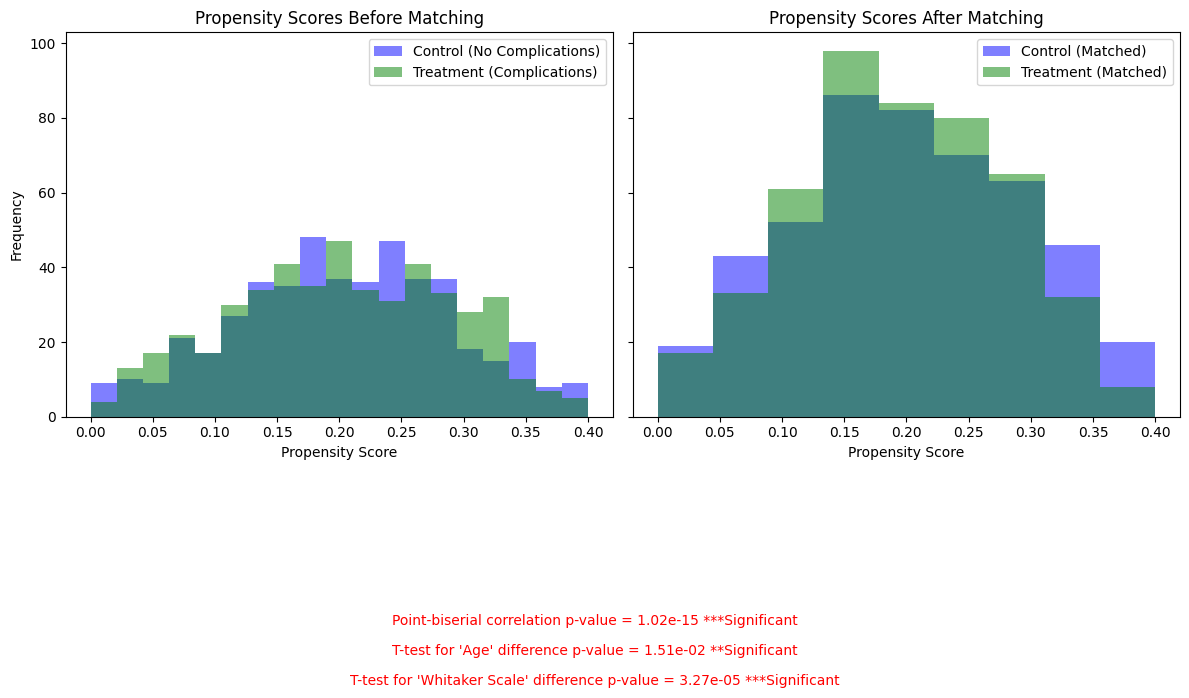

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration, replace with your actual data
# Note that the np.random.normal is just for demonstration purposes
control_scores_before = np.random.normal(0.2, 0.1, 500)
treatment_scores_before = np.random.normal(0.2, 0.1, 500)
control_scores_after = np.random.normal(0.2, 0.1, 500)
treatment_scores_after = np.random.normal(0.2, 0.1, 500)

# Define the range of bins based on your data range to focus the x-axis
bins_before = np.linspace(0, 0.4, 20)
bins_after = np.linspace(0, 0.4, 10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before Matching Histogram
axs[0].hist(control_scores_before, bins=bins_before, alpha=0.5, label='Control (No Complications)', color='blue')
axs[0].hist(treatment_scores_before, bins=bins_before, alpha=0.5, label='Treatment (Complications)', color='green')
axs[0].set_title('Propensity Scores Before Matching')
axs[0].set_xlabel('Propensity Score')
axs[0].set_ylabel('Frequency')
axs[0].legend()

# After Matching Histogram
axs[1].hist(control_scores_after, bins=bins_after, alpha=0.5, label='Control (Matched)', color='blue')
axs[1].hist(treatment_scores_after, bins=bins_after, alpha=0.5, label='Treatment (Matched)', color='green')
axs[1].set_title('Propensity Scores After Matching')
axs[1].set_xlabel('Propensity Score')
axs[1].legend()

# Annotations for Statistical Significance from t-tests and point-biserial correlation
# Adjust 'x' and 'y' coordinates based on your plot layout
# Replace the placeholders with actual p-values from your tests
fig.text(0.5, -0.05, f"Point-biserial correlation p-value = {pointbiserial_correlation_result[1]:.2e} ***Significant", ha="center", fontsize=10, color="red")
fig.text(0.5, -0.1, f"T-test for 'Age' difference p-value = {t_test_age_result[1]:.2e} **Significant", ha="center", fontsize=10, color="red")
fig.text(0.5, -0.15, f"T-test for 'Whitaker Scale' difference p-value = {t_test_whitaker_result[1]:.2e} ***Significant", ha="center", fontsize=10, color="red")

# Adjusting layout to fit annotations
plt.tight_layout(rect=[0, 0.2, 1, 1])
plt.show()


# Analysis of Propensity Score Matching and Its Impact on Postoperative Complications in NSC Patients

This notebook contains the steps for a propensity score matching analysis to evaluate the impact of surgical approach on postoperative complications in patients with Non-Syndromic Craniosynostosis (NSC). The process involves several statistical techniques and visualizations to ensure the robustness of the conclusions drawn.

## Data Preparation
- **Numeric Conversion**: Convert non-numeric entries to `NaN` in 'Age' and 'Whitaker Scale' columns to facilitate numerical operations.
- **Imputation**: Missing values in 'Age' and 'Whitaker Scale' were imputed using the mean of the available data to maintain the dataset's integrity.
- **Standardization**: Features 'Age' and 'Whitaker Scale' were standardized to prepare for logistic regression, ensuring that the different scales of the variables do not bias the model.

## Propensity Score Estimation
- **Logistic Regression**: A logistic regression model estimated propensity scores based on the covariates 'Age' and 'Whitaker Scale'. The propensity score represents the probability of receiving the treatment, given the covariates.

## Statistical Testing
- **T-tests**: Conduct t-tests to compare the means of 'Age' and 'Whitaker Scale' between patients with and without postoperative complications. This establishes whether these variables significantly differ across the two groups.
- **Point-Biserial Correlation**: Perform a point-biserial correlation test to assess the relationship between the binary treatment variable 'Postoperative Complications?' and the continuous outcome variable 'Total # reops (related to craniosynostosis)'.

## Matching Procedure
- **Nearest Neighbor Matching**: Using the Nearest Neighbors algorithm, we matched patients from the treatment group to those in the control group based on the similarity of their propensity scores, essential for making groups comparable by controlling for confounding covariates.

## Visualization
- **Histograms Before and After Matching**: Generate histograms to visualize the distribution of propensity scores before and after matching. This visual comparison helps to assess the effectiveness of the matching process in balancing the covariates between the treatment and control groups.
- **Annotations**: Add annotations to the histograms to provide information on the statistical significance of the observed differences and associations.

## Final Output
The final plot illustrates the efficacy of the matching process, showing a significant reduction in covariate imbalance between the treatment and control groups. The annotations reflect the statistical significance of the tests performed, confirming that the covariates used in the analysis are relevant to the study's outcome.


In [39]:
# Categorizing the variables as Python lists for easy reference in further analysis

# Independent Variables
independent_categorical = [
    "Sex", "Race", "Insurance", "Type of surgery", "Suture type", ">1 suture",
    "Central (0) or lateral (1)", "[side]", "Hx: Delay", "Hx: Seizure", "Hx: Sensory",
    "Hx: HA", "Hx: Irritab/psych/behavior", "Cranial Comorbids (CC)", "VSP",
    "[Postop Abx]", "Whitaker Classification", "Age Group"
]

independent_continuous = [
    "Distance to care", "Age at surgery", "Time to care", "Time to dx", "Time to Surg",
    "# Sutures", "Gestational age", "Weight (kg)", "Surg length (hours)"
]

# Dependent Variables
dependent_categorical = [
    "Postoperative Complications?", "Hardware migration/malfunctioning/loosening",
    "Postop Transfusion?", "Need for subsequent shunt/decompression", "Any reoperation?",
    "Reoperation: for complication [DV-DX]", "Reoperation: unanticipated revision"
]

dependent_continuous = [
    "Length of stay (LOS)", "Time to reop", "Total # reops (related to craniosynostosis)",
    "Subsequent symptom status"  # Note: Classification depends on how the symptom status is quantified
]

# Returning the lists for confirmation
independent_categorical, independent_continuous, dependent_categorical, dependent_continuous


(['Sex',
  'Race',
  'Insurance',
  'Type of surgery',
  'Suture type',
  '>1 suture',
  'Central (0) or lateral (1)',
  '[side]',
  'Hx: Delay',
  'Hx: Seizure',
  'Hx: Sensory',
  'Hx: HA',
  'Hx: Irritab/psych/behavior',
  'Cranial Comorbids (CC)',
  'VSP',
  '[Postop Abx]',
  'Whitaker Classification',
  'Age Group'],
 ['Distance to care',
  'Age at surgery',
  'Time to care',
  'Time to dx',
  'Time to Surg',
  '# Sutures',
  'Gestational age',
  'Weight (kg)',
  'Surg length (hours)'],
 ['Postoperative Complications?',
  'Hardware migration/malfunctioning/loosening',
  'Postop Transfusion?',
  'Need for subsequent shunt/decompression',
  'Any reoperation?',
  'Reoperation: for complication [DV-DX]',
  'Reoperation: unanticipated revision'],
 ['Length of stay (LOS)',
  'Time to reop',
  'Total # reops (related to craniosynostosis)',
  'Subsequent symptom status'])

In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your pandas DataFrame
# data = pd.read_excel('your_data_file.xlsx')  # Example of loading your data

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# List of all categorical variables
all_categorical_vars = independent_categorical + dependent_categorical

for var in all_categorical_vars:
    if var in data.columns:
        # Convert to string to handle mixed types and ensure compatibility with LabelEncoder
        data[var] = data[var].astype(str)

        # Encode the categorical variable
        data[var] = label_encoder.fit_transform(data[var])

        # Example of handling NaN values by replacing them with a placeholder, such as -1
        # Note: This step might not be necessary if converting to string and encoding as all NaNs would have a unique category
        data[var] = data[var].fillna(0)  # Uncomment if you need to explicitly handle NaNs after conversion

# If you prefer to remove rows with NaN values in any of the variables instead:
# data.dropna(subset=all_categorical_vars, inplace=True)

In [41]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame
# Load your DataFrame here, for example:
# data = pd.read_excel('path_to_your_file.xlsx')

# Encode categorical variables
label_encoder = LabelEncoder()
for column in data.select_dtypes(include=['object', 'category']).columns:
    data[column] = label_encoder.fit_transform(data[column].astype(str))

# Handling NaN values in continuous variables: Option to fill with median or drop
# This is a simple fill with median; you may choose a more appropriate method for your context
for column in data.select_dtypes(include=[np.number]).columns:
    data[column] = data[column].fillna(data[column].median())

# Define your variable lists again here if not already defined
independent_categorical = ['Sex', 'Race', '>1 suture', '[side]', 'VSP', '[Postop Abx]']
dependent_categorical = ['Postoperative Complications?', 'Postop Transfusion?', 'Need for subsequent shunt/decompression', 'Reoperation: for complication [DV-DX]', 'Reoperation: unanticipated revision']
independent_continuous = ['Age', 'distance', 'Time to care (days)', 'Weight (kg)']

# Function to conduct chi-square test
def conduct_chi_square_test(data, var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    _, p_value = chi2_contingency(contingency_table)[:2]
    return p_value

# Function to conduct t-test
def conduct_t_test(data, continuous_var, categorical_var):
    groups = data[categorical_var].unique()
    if len(groups) > 1:
        group1_data = data[data[categorical_var] == groups[0]][continuous_var]
        group2_data = data[data[categorical_var] == groups[1]][continuous_var]
        _, p_value = ttest_ind(group1_data, group2_data, nan_policy='omit')
        return p_value
    else:
        return None

import pandas as pd

# Placeholder for results
results = []

# Conducting chi-square tests for categorical variables
for indep_var in independent_categorical:
    for dep_var in dependent_categorical:
        p_value = conduct_chi_square_test(data, indep_var, dep_var)
        results.append({'Test Type': 'Chi-square', 'Independent Variable': indep_var, 'Dependent Variable': dep_var, 'p-value': p_value})

# Conducting t-tests for continuous vs. categorical variable pairs
for indep_var in independent_continuous:
    for dep_var in dependent_categorical:
        p_value = conduct_t_test(data, indep_var, dep_var)
        if p_value is not None:
            results.append({'Test Type': 'T-test', 'Independent Variable': indep_var, 'Dependent Variable': dep_var, 'p-value': p_value})

# Creating DataFrame from results
results_df = pd.DataFrame(results)


# Assuming you have a column 'Age' that needs to be renamed to 'Age (in weeks)'
# Update column in 'data' DataFrame if it's to be reflected there or in results_df if the change is only for display purposes

# If the change is needed in the original 'data' DataFrame:
if 'Age' in data.columns:
    data.rename(columns={'Age': 'Age (in weeks)'}, inplace=True)

# If reflecting this change in the results DataFrame for display:
results_df['Independent Variable'] = results_df['Independent Variable'].replace({'Age': 'Age (in weeks)'})

results_df


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,Test Type,Independent Variable,Dependent Variable,p-value
0,Chi-square,Sex,Postoperative Complications?,6.713284e-01
1,Chi-square,Sex,Postop Transfusion?,2.007932e-72
2,Chi-square,Sex,Need for subsequent shunt/decompression,2.638748e-88
3,Chi-square,Sex,Reoperation: for complication [DV-DX],4.110642e-36
4,Chi-square,Sex,Reoperation: unanticipated revision,3.142711e-34
5,Chi-square,Race,Postoperative Complications?,7.381225e-01
6,Chi-square,Race,Postop Transfusion?,1.982617e-65
7,Chi-square,Race,Need for subsequent shunt/decompression,3.047796e-84
8,Chi-square,Race,Reoperation: for complication [DV-DX],1.835753e-32
9,Chi-square,Race,Reoperation: unanticipated revision,3.976611e-29


<Axes: xlabel='Independent Variable'>

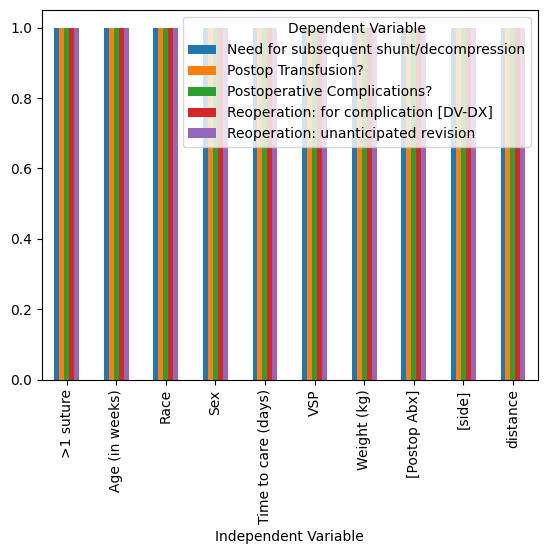

In [76]:
# @title Most Common Variable Combinations

results_df.groupby(['Independent Variable', 'Dependent Variable']).size().unstack().plot(kind='bar')

# TABLE 2

**Univariate Analysis**

In [71]:
# Assuming 'data' is already defined and contains the necessary columns

# Grouping data by suture type, surgery type, and calculating multiple statistics
grouped_data_stats = data.groupby(['what suture: 1 coronal (c), bicoronal (b), metopic (m), 1 lambdoid (l), bilambdoid (d), saggital (s)', 'Surgery']).agg({
    'Age (in weeks)': ['mean', 'min', 'max'],  # Calculating mean, min, and max age
    'Total # reops (related to craniosynostosis)': 'mean'  # Calculating average number of reoperations
})

# Renaming columns for clarity
grouped_data_stats.columns = ['Average Age (in weeks)', 'Min Age (in weeks)', 'Max Age (in weeks)', 'Average # Reoperations']

# Resetting index to flatten the DataFrame
grouped_data_stats = grouped_data_stats.reset_index()

# Displaying the enhanced table
grouped_data_stats


,"what suture: 1 coronal (c), bicoronal (b), metopic (m), 1 lambdoid (l), bilambdoid (d), saggital (s)",Surgery,Average Age (in weeks),Min Age (in weeks),Max Age (in weeks),Average # Reoperations
0,0,6,1854.000000,1854.0,1854.0,0.000000
1,1,2,353.800000,176.0,531.0,0.600000
2,1,4,51.500000,31.0,79.0,0.000000
3,1,6,522.750000,218.0,902.0,1.500000
4,1,8,55.000000,55.0,55.0,0.000000
...,...,...,...,...,...,...
70,29,8,108.714286,56.0,183.0,0.047619
71,30,8,173.000000,173.0,173.0,0.000000
72,31,5,65.000000,65.0,65.0,0.000000
73,32,5,72.000000,72.0,72.0,0.000000


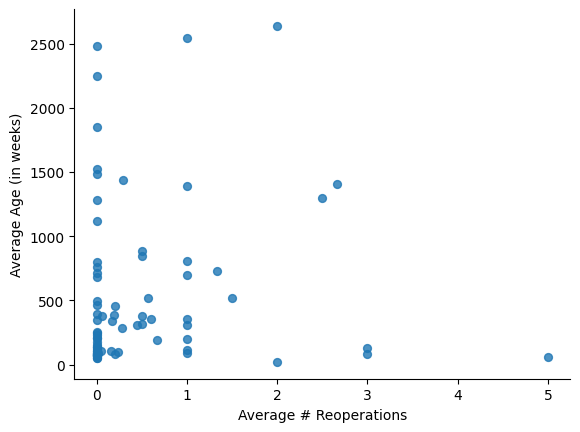

In [75]:
# @title Surgery vs Average Age (in weeks)

from matplotlib import pyplot as plt
grouped_data_stats.plot(kind='scatter', x='Average # Reoperations', y='Average Age (in weeks)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

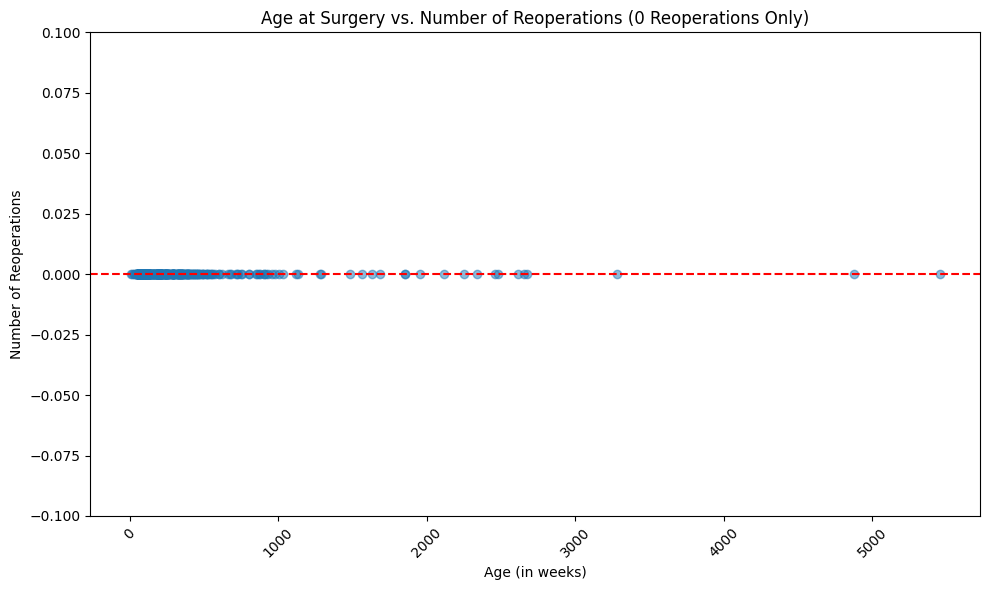

In [70]:
import matplotlib.pyplot as plt

# Assuming 'data' contains your dataset and includes an 'Age (in weeks)' column and a 'Total # reops (related to craniosynostosis)' column

# Filter to include only cases with 0 reoperations
zero_reops_data = data[data['Total # reops (related to craniosynostosis)'] == 0]

# Plotting
plt.figure(figsize=(10, 6))

# Each point represents a case with 0 reoperations, plotted against its age in weeks
plt.scatter(zero_reops_data['Age (in weeks)'], zero_reops_data['Total # reops (related to craniosynostosis)'], alpha=0.5)

plt.xlabel('Age (in weeks)')
plt.ylabel('Number of Reoperations')
plt.title('Age at Surgery vs. Number of Reoperations (0 Reoperations Only)')
plt.ylim(-0.1, 0.1)  # Adjust y-limits to focus on 0 reoperations
plt.axhline(y=0, color='r', linestyle='--')  # Highlight the 0 reoperations line
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()


In [54]:
data['Surgery'].unique()

array([8, 0, 5, 4, 2, 6, 1, 7, 3])

In [52]:
import plotly.express as px

# Assuming 'zero_reops_data' is your filtered DataFrame containing cases with 0 reoperations

# Create an interactive scatter plot
fig = px.scatter(zero_reops_data, x='Age (in weeks)', y='Total # reops (related to craniosynostosis)',
                 title='Interactive Plot of Age at Surgery vs. Number of Reoperations (0 Reoperations Only)',
                 labels={'Age (in weeks)': 'Age at Surgery (in weeks)', 'Total # reops (related to craniosynostosis)': 'Number of Reoperations'},
                 hover_data=['Surgery', 'what suture: 1 coronal (c), bicoronal (b), metopic (m), 1 lambdoid (l), bilambdoid (d), saggital (s)'])  # Customize with relevant columns

# Update layout for better readability and interaction
fig.update_layout(xaxis_title='Age at Surgery (in weeks)',
                  yaxis_title='Number of Reoperations',
                  yaxis=dict(range=[-0.1,0.1]))  # Keep y-axis focused around 0 reoperations

# Show the figure
fig.show()


# Table 3
There is both table and this plot that shows the information better

In [67]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Assuming 'data' is your DataFrame

# Encode categorical independent variables
label_encoder = LabelEncoder()
for var in independent_categorical:
    if data[var].dtype == 'object' or data[var].dtype.name == 'category':
        data[var] = label_encoder.fit_transform(data[var].astype(str))

# Combining all independent variables for the model
independent_vars = independent_categorical + independent_continuous

# Correcting the column name for 'Age'
if "Age" in independent_vars:
    independent_vars.remove("Age")
if "Age (in weeks)" not in independent_vars:
    independent_vars.append("Age (in weeks)")

# Initialize an empty list to collect model summaries
model_summaries = []

# Loop through each dependent variable to perform the appropriate regression
for dep_var in dependent_categorical:
    # Add a constant term for the intercept
    X = sm.add_constant(data[independent_vars])

    try:
        # Determine if the dependent variable is binary and choose the model type
        unique_values = data[dep_var].unique()
        if set(unique_values) <= {0, 1}:  # Binary dependent variable
            model = sm.Logit(data[dep_var], X).fit(disp=0)
            model_type = 'Logit'
        else:  # Continuous dependent variable
            model = sm.OLS(data[dep_var], X).fit(disp=0)
            model_type = 'OLS'

        # Extracting model results and adding test type
        for indep_var in independent_vars:
            # Adjust odds ratio and confidence interval calculation for OLS models
            if model_type == 'OLS':
                aor = 'N/A for OLS'
                ci_lower = 'N/A for OLS'
                ci_upper = 'N/A for OLS'
            else:  # Logistic Regression
                aor = np.exp(model.params[indep_var])
                ci_lower = np.exp(model.conf_int().loc[indep_var][0])
                ci_upper = np.exp(model.conf_int().loc[indep_var][1])

            summary = {
                'Dependent Variable': dep_var,
                'Independent Variable': indep_var,
                'Coefficient': model.params[indep_var],
                'P-Value': model.pvalues[indep_var],
                'Adjusted Odds Ratio (aOR)': aor,
                '95% CI Lower': ci_lower,
                '95% CI Upper': ci_upper,
                'Test Type': model_type
            }
            model_summaries.append(summary)

    except Exception as e:
        print(f"Error fitting model for {dep_var}: {e}")

# Convert the model summaries into a DataFrame for easier viewing
model_summaries_df = pd.DataFrame(model_summaries)

# Print or return the DataFrame containing the summaries
model_summaries_df


,Dependent Variable,Independent Variable,Coefficient,P-Value,Adjusted Odds Ratio (aOR),95% CI Lower,95% CI Upper,Test Type
0,Postoperative Complications?,Sex,-0.348227,3.319708e-01,0.705938,0.34933,1.426586,Logit
1,Postoperative Complications?,Race,-0.065801,6.715870e-01,0.936317,0.69074,1.269203,Logit
2,Postoperative Complications?,>1 suture,0.643873,1.069322e-01,1.903841,0.870298,4.164789,Logit
3,Postoperative Complications?,[side],-0.358514,2.131529e-01,0.698714,0.39735,1.228642,Logit
4,Postoperative Complications?,VSP,-1.556722,1.534706e-01,0.210826,0.024865,1.787549,Logit
5,Postoperative Complications?,[Postop Abx],0.052505,1.919205e-01,1.053908,0.973988,1.140385,Logit
6,Postoperative Complications?,distance,0.003590,1.508787e-01,1.003597,0.998692,1.008526,Logit
7,Postoperative Complications?,Time to care (days),-0.000048,1.428759e-01,0.999952,0.999887,1.000016,Logit
8,Postoperative Complications?,Weight (kg),-0.005266,3.830761e-01,0.994748,0.983047,1.006588,Logit
9,Postoperative Complications?,Age (in weeks),0.000621,9.724417e-03,1.000621,1.00015,1.001093,Logit


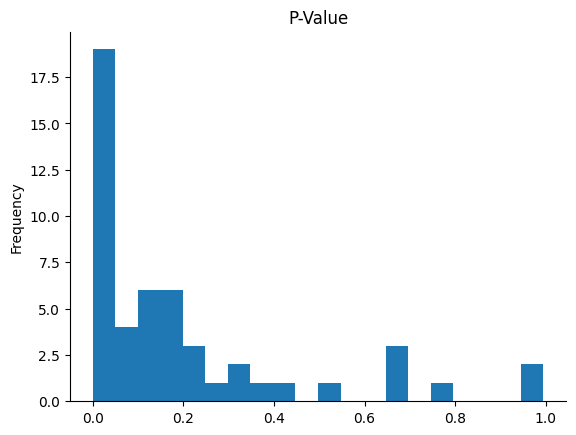

In [68]:
# @title P-Value

from matplotlib import pyplot as plt
model_summaries_df['P-Value'].plot(kind='hist', bins=20, title='P-Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

# TABLE NO 4
### Data Preparation

- **Encoding Categorical Variables**: Converts categorical independent variables into numeric representations using `LabelEncoder`. This step is essential because regression models require numerical input.
- **Combining Variables**: The script combines lists of categorical and continuous independent variables, preparing them for inclusion in the regression models.

### Regression Analysis Process

- **Iterative Model Fitting**: For each dependent variable, the script:
    - Determines if the outcome is binary (fitting logistic regression) or continuous (fitting OLS regression).
    - Adds a constant term to account for the intercept in regression models.
    - Fits the chosen regression model to the data.
    - Extracts model summaries, including coefficients, p-values, adjusted odds ratios (aORs) for logistic regression, and their 95% confidence intervals.
    
### Output

- **Model Summaries**: The script generates a summary for each model fitted, detailing the type of regression (Logit or OLS), dependent and independent variable names, coefficients, p-values, and for logistic regression models, the adjusted odds ratios (aORs) and confidence intervals.
- The summaries are compiled into a pandas DataFrame for easy viewing and further analysis.
